#### 1. import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')

#### 2. Defining functions to generate derived features

In [3]:
# Basic & fundamental functions to analize data
def wap(df):
    a1 = df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']
    # a2 = df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2']
    a2 = 0
    # b = df['bid_size1'] + df['ask_size1'] + df['bid_size2']+ df['ask_size2']
    b = df['bid_size1'] + df['ask_size1']
    return (a1 + a2) / b

def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff()

def realized_volatility(series_log_return):  # only for wap column.
    return np.sqrt(np.sum(series_log_return**2))

# Functions generating new derived features
# 1. skewness : for most of all features
# def skewness(col_data):
#     col_mean = col_data.mean()
#     diff = col_data - col_mean
#     try :
#         return (diff**3).mean() / ((diff**2).mean())**(3/2)
#     except ZeroDivisionError as e:
#         print(e)
#         return 0

# 1-2. pearson skewness (skewness above sometimes raises ZeroDivisionError)
def skewness(col_data):
    try :
        return 3*(col_data.mean() - col_data.median())/col_data.std()
    except ZeroDivisionError as e:
        print(e, '- skewness')
        return 0

# 2. kurtosis : for seconds_in_bucket, and wap
def kurtosis(col_data):
    col_mean = col_data.mean()
    diff = col_data - col_mean
    try :
        return (diff**4).mean() / ((diff**2).mean())**2 - 3
    except ZeroDivisionError as e:
        print(e, '- kurtosis')
        return -3

# 3. right_skew : for seconds_in_bucket. 
def right_skew(col_data): # only for seconds_in_bucket column.
    return (col_data[col_data>=300]-300).sum() / (col_data>=300).sum()

# 4. number of rows in trade_train is also needed. Maybe should generate once again..


#### NO USE, because of correlation with features above (or just doesn't needed) ####
def median_abs_deviation(col_data): # no use
    col_median = col_data.median()
    abs_diff = np.abs(col_data-col_median)
    return abs_diff.median()

def TR(col_data): # very close to realized volatility
    return col_data.max() - col_data.min()

# should remake this function for column data, not df data
def sizes_func(): ## 마지막 행의 size에 대해. 사실 더 많은 데이터를 사용하고싶은데 그럴수 있을지 모르겠음
    sizes = list(book_df.iloc[-1]['bid_size1' : 'ask_size2'])
    return sizes

#### 3. Generating new dataframe of derived variables

In [6]:
# stock_id list for reading parquet files
stock_id_list = list(train.stock_id.value_counts().index)
stock_id_list.sort()

# new derived features' columns
cols =  ['realized_volatility',
         'seconds_count',
         'seconds_right_skew',
         'seconds_skewness',
         'seconds_kurtosis',
         'wap_skewness',
         'wap_kurtosis',
         'bid_size1_skewness',
         'bid_size1_max',
         'bid_size1_mean',
         'ask_size1_skewness',
         'ask_size1_max',
         'ask_size1_mean',
         'bid_size2_skewness',
         'ask_size2_skewness',
         'row_id',
         'size_max',
         'size_sum',
         'order_count_max']

# generate empty dataframe. 
merged_df = pd.DataFrame(columns = cols, dtype = 'float64')

# Generating new dataframe with derived features
for stock in stock_id_list:
    print("current stock : "+str(stock))
    
    # 1. book data
    tmp_book = pd.read_parquet('data/book_train.parquet/stock_id={}'.format(stock))
    method_list = [skewness, kurtosis]
    tmp_book['wap'] = wap(tmp_book)
    tmp_book['log_return'] = tmp_book.groupby(['time_id'])['wap'].apply(log_return)
    groupby_book = tmp_book.groupby(['time_id']).agg({'log_return':realized_volatility,
                                      'seconds_in_bucket':['count',right_skew]+method_list,
                                      'wap':method_list,
                                      'bid_size1':[skewness,'max','mean'],
                                      'ask_size1':[skewness,'max','mean'],
                                      'bid_size2':skewness,
                                      'ask_size2':skewness})

    groupby_book.reset_index(inplace = True)
    groupby_book['row_id'] = groupby_book['time_id'].apply(lambda x: str('{}-{}'.format(stock, x)))
    groupby_book.drop(['time_id'], axis = 1, inplace = True)
    groupby_book.head()
    groupby_book.columns = ['realized_volatility', 'seconds_count','seconds_right_skew',
                       'seconds_skewness','seconds_kurtosis','wap_skewness','wap_kurtosis',
                       'bid_size1_skewness','bid_size1_max','bid_size1_mean',
                       'ask_size1_skewness','ask_size1_max','ask_size1_mean',
                       'bid_size2_skewness','ask_size2_skewness','row_id']

    # 2. trade data
    tmp_trade = pd.read_parquet('data/trade_train.parquet/stock_id={}'.format(stock))
    tmp_trade['log_return'] = tmp_trade.groupby(['time_id'])['price'].apply(log_return)
    groupby_trade = tmp_trade.groupby(['time_id']).agg({
                                        'size':['max','sum'],
                                        'order_count':'max'})

    groupby_trade.reset_index(inplace = True)
    groupby_trade['row_id'] = groupby_trade['time_id'].apply(lambda x: str('{}-{}'.format(stock, x)))
    groupby_trade.drop(['time_id'], axis = 1, inplace = True)
    groupby_trade.head()
    groupby_trade.columns = ['size_max','size_sum',
                            'order_count_max','row_id']

    new_df = pd.merge(groupby_book, groupby_trade, how='outer', on='row_id')
    
    merged_df = pd.concat([merged_df, new_df], ignore_index = True)

current stock : 0


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 1


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 2


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 3


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 4


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 5


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 6


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 7


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 8


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 9


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 10


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 11


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 13


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 14


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 15


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 16


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 17


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 18
float division by zero - skewness
float division by zero - skewness
float division by zero - skewness


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 19


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 20


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 21


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 22


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 23


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 26


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 27


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 28


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 29


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 30


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 31


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 32


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 33


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 34


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 35


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 36


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 37
float division by zero - skewness


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 38


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 39


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 40


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 41


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 42


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 43


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 44


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 46


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 47


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 48


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 50


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 51


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 52


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 53


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 55


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 56


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 58


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 59


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 60


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 61


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 62


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 63


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 64


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 66


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 67


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 68


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 69


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 70


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 72


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 73


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 74


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 75


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 76


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 77


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 78


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 80


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 81


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 82


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 83


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 84


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 85


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 86


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 87


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 88


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 89


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 90


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 93


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 94


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 95


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 96


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 97


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 98


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 99


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 100


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 101


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 102


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 103


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 104


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 105


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 107


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 108


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 109


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 110


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 111


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 112


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 113


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 114


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 115


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 116


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 118


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 119


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 120


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 122


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 123


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 124


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 125


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


current stock : 126


C:\Users\frank\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


In [9]:
merged_df

,realized_volatility,seconds_count,seconds_right_skew,seconds_skewness,seconds_kurtosis,wap_skewness,wap_kurtosis,bid_size1_skewness,bid_size1_max,bid_size1_mean,ask_size1_skewness,ask_size1_max,ask_size1_mean,bid_size2_skewness,ask_size2_skewness,row_id,size_max,size_sum,order_count_max
0,0.004499,302.0,152.841727,0.510418,-1.181185,-0.853924,3.512603,-0.803095,500.0,78.264901,-0.246879,228.0,74.579470,-0.669089,-0.426180,0-5,499.0,3179.0,12.0
1,0.001204,200.0,147.965217,-0.362378,-1.001272,0.091449,0.511806,0.288387,402.0,149.965000,1.345276,400.0,71.145000,1.269870,-0.172575,0-11,280.0,1289.0,6.0
2,0.002369,188.0,159.897059,0.506732,-1.216982,-0.960020,-0.131697,-0.164424,304.0,96.132979,1.279381,449.0,131.037234,0.538682,-1.122790,0-16,391.0,2161.0,8.0
3,0.002574,120.0,120.509434,-0.032548,-1.013334,0.692342,-0.116944,0.448781,370.0,114.458333,0.480632,400.0,120.800000,1.293843,0.790816,0-31,450.0,1962.0,15.0
4,0.001894,176.0,131.988764,-0.402382,-1.151718,0.377272,-1.027612,0.579404,402.0,119.823864,0.121758,333.0,88.477273,-0.434153,1.519461,0-62,341.0,1791.0,17.0
5,0.007902,263.0,134.974790,-0.003396,-1.254631,-0.148425,-0.424146,0.505167,441.0,115.904943,0.026858,382.0,100.882129,1.314050,1.823758,0-72,438.0,3395.0,16.0
6,0.010034,368.0,145.463855,0.212152,-1.197545,-0.176466,-1.337017,0.019720,300.0,100.432065,-0.084501,315.0,98.146739,-1.346409,1.245680,0-97,308.0,2279.0,9.0
7,0.005331,294.0,137.972477,0.583891,-1.001271,0.085918,-1.021313,0.303460,502.0,111.853741,1.292132,259.0,57.687075,1.901615,-1.754934,0-103,334.0,1181.0,16.0
8,0.001797,236.0,139.822034,-0.200396,-1.248008,-0.927618,0.184021,1.284626,403.0,148.436441,-1.828764,200.0,62.173729,0.073885,1.715628,0-109,362.0,1868.0,6.0
9,0.003273,436.0,148.360190,0.107755,-1.191529,0.103256,0.375606,0.689217,490.0,123.644495,-0.387842,370.0,83.961009,-0.824230,1.768613,0-123,468.0,5135.0,13.0


#### 4. Correlation analysis - what should i do next? (PCA or Just remove high-correlated features)

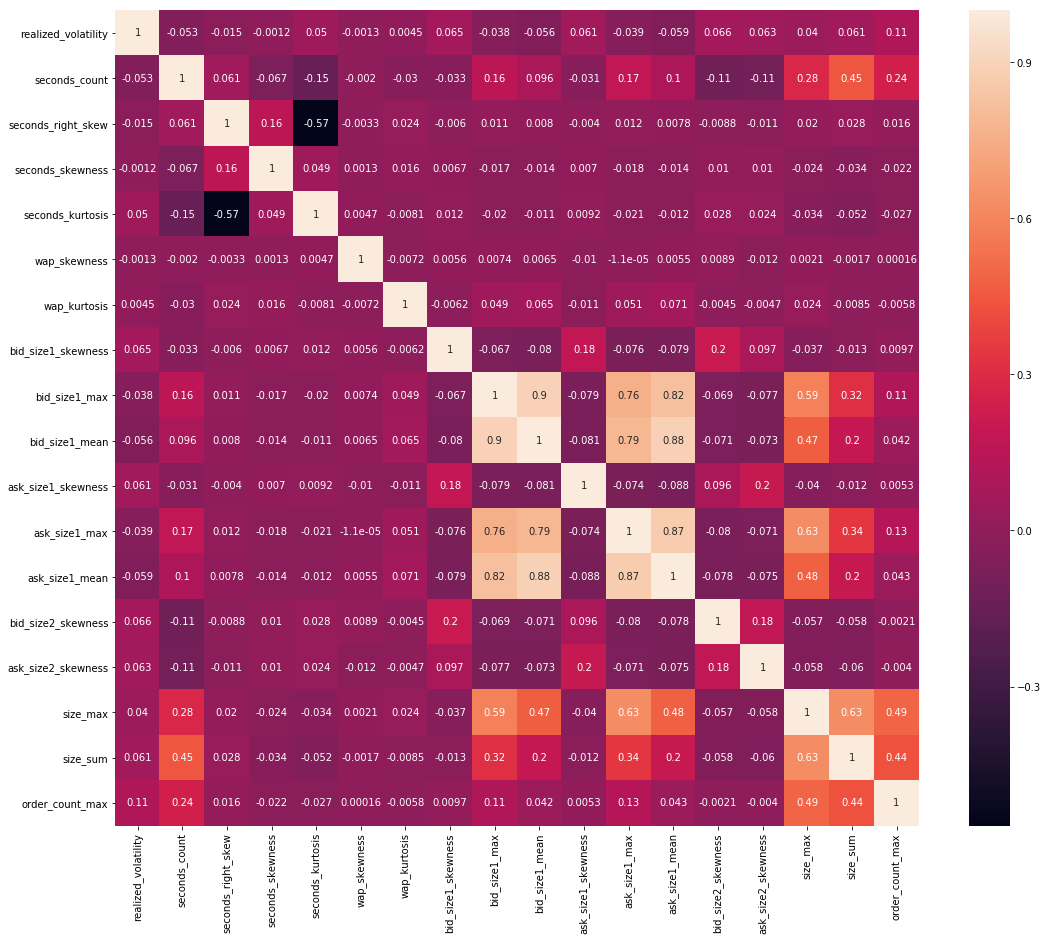

In [10]:
plt.figure(figsize = (18, 15))
sns.heatmap(merged_df.corr(), annot = True)

#### 5. Fill nan & Save dataframe as .csv file

In [5]:
merged_df = pd.read_csv('data/preprocessed_0812.csv') # delete later.

In [11]:
train['row_id'] = train['stock_id'].astype('str')+"-"+train['time_id'].astype('str')
train.drop(['stock_id','time_id'], axis=1, inplace = True)
merged_df = pd.merge(merged_df, train, how = 'outer', on = 'row_id')

merged_df['size_max'] = merged_df['size_max'].fillna(0)
merged_df['size_sum'] = merged_df['size_sum'].fillna(0)
merged_df['order_count_max'] = merged_df['order_count_max'].fillna(0)

In [12]:
# !!! change file name !!!
merged_df.to_csv('data/preprocessed_0815.csv', index = False)

#### (Additional) 6. Fit RandomForest & XGBoostRegressor

In [13]:
merged_df[merged_df.isna().any(axis=1)]

,realized_volatility,seconds_count,seconds_right_skew,seconds_skewness,seconds_kurtosis,wap_skewness,wap_kurtosis,bid_size1_skewness,bid_size1_max,bid_size1_mean,ask_size1_skewness,ask_size1_max,ask_size1_mean,bid_size2_skewness,ask_size2_skewness,row_id,size_max,size_sum,order_count_max,target


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error, r2_score

X, y = merged_df.drop(['row_id', 'target'], axis=1), merged_df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [14]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(343145, 18)
(343145,)
(85787, 18)
(85787,)


In [15]:
best_rf = RandomForestRegressor(n_estimators=65, max_depth=10, min_samples_split=5,
                                min_samples_leaf=4, max_features='auto', bootstrap=True)
best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)
print('rf RMSE :', np.sqrt(mean_squared_error(y_test, y_pred)))
print('rf R2 :', r2_score(y_test, y_pred))
y_test_df = pd.DataFrame({'y_test':y_test, 'y_pred':y_pred})
y_test_df['rmspe_before'] = ((y_test_df.y_test-y_test_df.y_pred)/y_test_df.y_test)**2
print('rf RMSPE :',np.sqrt(y_test_df.rmspe_before.sum()/len(y_test_df)))


best_xgbr = XGBRegressor(objective = 'reg:squarederror',
                    learning_rate = 0.1,
                    n_estimators = 100,
                    max_depth = 7,
                    min_child_weight = 5,
                    colsample_bytree = 0.7,
                    subsample = 0.9,
                    gamma = 0,
                    reg_alpha = 0.01)

best_xgbr.fit(X_train, y_train)
y_pred = best_xgbr.predict(X_test)
print('xgb RMSE :', np.sqrt(mean_squared_error(y_test, y_pred)))
print('xgb R2 :', r2_score(y_test, y_pred))
y_test_df = pd.DataFrame({'y_test':y_test, 'y_pred':y_pred})
y_test_df['rmspe_before'] = ((y_test_df.y_test-y_test_df.y_pred)/y_test_df.y_test)**2
print('xgb RMSPE :',np.sqrt(y_test_df.rmspe_before.sum()/len(y_test_df)))

rf RMSE : 0.0013539421517952486
rf R2 : 0.784006781296687
rf RMSPE : 0.30289914666198436


C:\Users\frank\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


xgb RMSE : 0.0013485216891425762
xgb R2 : 0.7857327628355446
xgb RMSPE : 0.3051482288218793


In [16]:
best_rf.feature_importances_

array([0.95070453, 0.00521568, 0.0015963 , 0.00168284, 0.00247421,
       0.00191837, 0.00283278, 0.0013437 , 0.0023427 , 0.0089609 ,
       0.00123869, 0.00169981, 0.00458075, 0.00185788, 0.00178833,
       0.00551851, 0.00290068, 0.00134336])

In [17]:
best_xgbr.feature_importances_

array([0.83779454, 0.01143222, 0.00541329, 0.00531835, 0.00652502,
       0.00561137, 0.00923618, 0.00517012, 0.00699179, 0.03083511,
       0.00588863, 0.00576888, 0.02734808, 0.00811865, 0.00497639,
       0.00991883, 0.00717313, 0.00647951], dtype=float32)

In [28]:
rank = best_xgbr.feature_importances_.argsort()

In [27]:
print(X.columns[rank[-1]])
print(X.columns[rank[-2]])
print(X.columns[rank[-3]])
print(X.columns[rank[-4]])
print(X.columns[rank[-5]])

realized_volatility
bid_size1_mean
ask_size1_mean
seconds_count
size_max


In [29]:
rank_rf = best_rf.feature_importances_.argsort()

In [30]:
print(X.columns[rank_rf[-1]])
print(X.columns[rank_rf[-2]])
print(X.columns[rank_rf[-3]])
print(X.columns[rank_rf[-4]])
print(X.columns[rank_rf[-5]])

realized_volatility
bid_size1_mean
size_max
seconds_count
ask_size1_mean


In [120]:
y_test_df

,y_test,y_pred,rmspe_before
195069,0.002386,0.002398,2.517787e-05
213200,0.005324,0.005341,1.106302e-05
243028,0.001101,0.001124,4.518015e-04
140804,0.001147,0.001231,5.305463e-03
264127,0.005478,0.005578,3.382089e-04
76315,0.001732,0.001763,3.244883e-04
72104,0.001601,0.001649,8.917817e-04
230925,0.002976,0.002989,2.163276e-05
411452,0.002437,0.002441,2.625725e-06
46547,0.003223,0.003198,6.250725e-05


In [12]:
merged_df.head()

,realized_volatility,seconds_count,seconds_right_skew,seconds_skewness,seconds_kurtosis,wap_skewness,wap_kurtosis,bid_size1_skewness,bid_size1_max,bid_size1_mean,ask_size1_skewness,ask_size1_max,ask_size1_mean,bid_size2_skewness,ask_size2_skewness,row_id,size_max,size_sum,order_count_max,target
0,0.004106,302.0,152.841727,0.510418,-1.181185,-0.729681,3.300160,-0.803095,500.0,78.264901,-0.246879,228.0,74.579470,-0.669089,-0.426180,0-5,499.0,3179.0,12.0,0.004136
1,0.001507,200.0,147.965217,-0.362378,-1.001272,-0.053591,0.563174,0.288387,402.0,149.965000,1.345276,400.0,71.145000,1.269870,-0.172575,0-11,280.0,1289.0,6.0,0.001445
2,0.002468,188.0,159.897059,0.506732,-1.216982,-0.934322,0.324836,-0.164424,304.0,96.132979,1.279381,449.0,131.037234,0.538682,-1.122790,0-16,391.0,2161.0,8.0,0.002168
3,0.002708,120.0,120.509434,-0.032548,-1.013334,0.792628,0.111513,0.448781,370.0,114.458333,0.480632,400.0,120.800000,1.293843,0.790816,0-31,450.0,1962.0,15.0,0.002195
4,0.001932,176.0,131.988764,-0.402382,-1.151718,0.168761,-1.067718,0.579404,402.0,119.823864,0.121758,333.0,88.477273,-0.434153,1.519461,0-62,341.0,1791.0,17.0,0.001747


In [123]:
ex_df = pd.read_csv('data/preprocessed_0812.csv')
ex_df[ex_df.isna().any(axis=1)]

,realized_volatility,seconds_count,seconds_right_skew,seconds_skewness,seconds_kurtosis,wap_skewness,wap_kurtosis,bid_size1_skewness,bid_size1_max,bid_size1_mean,ask_size1_skewness,ask_size1_max,ask_size1_mean,bid_size2_skewness,ask_size2_skewness,row_id,size_max,size_sum,order_count_max
66123,0.006489,72.0,168.384615,-0.756764,-1.374748,-1.532107,-0.370196,-1.376687,190.0,62.930556,1.375049,6.0,2.777778,1.911837,-0.707118,18-8524,NaN,NaN,NaN
107340,0.000281,306.0,153.139535,-0.079413,-1.203048,-1.228994,-0.544553,-1.171386,98608.0,78395.271242,0.483706,112079.0,87529.539216,1.099528,0.001889,31-985,NaN,NaN,NaN
107715,0.000092,196.0,165.488372,0.419876,-1.339710,-0.845989,-0.444694,-1.661393,81846.0,65352.484694,0.925430,74566.0,68520.734694,-1.881426,2.160500,31-3987,NaN,NaN,NaN
107915,0.000219,445.0,150.188940,0.072658,-1.220699,-0.513839,5.548348,-0.708727,76047.0,61979.573034,0.214890,68297.0,51511.604494,-1.237132,-0.313861,31-5539,NaN,NaN,NaN
107922,0.000682,508.0,147.720000,-0.165907,-1.156867,-0.401912,-0.097735,1.026375,47900.0,26984.748031,-0.305908,43171.0,24838.718504,-2.219525,0.854228,31-5629,NaN,NaN,NaN
107999,0.000253,382.0,136.149733,-0.139442,-1.143397,-0.779985,1.357910,0.020516,65828.0,56488.183246,0.544897,119142.0,66780.513089,0.425850,0.452000,31-6197,NaN,NaN,NaN
108289,0.000275,346.0,155.068323,0.309139,-1.222936,-0.478159,0.135756,-0.858899,63041.0,47541.323699,0.345063,73076.0,56399.540462,-0.616785,0.757865,31-8753,NaN,NaN,NaN
108297,0.000131,200.0,133.344086,-0.114515,-1.068394,-0.085003,-0.666518,0.064237,142590.0,134243.840000,-0.052911,58988.0,52794.325000,0.045974,2.119204,31-8840,NaN,NaN,NaN
108339,0.000301,373.0,144.248731,-0.099758,-1.154891,-1.043756,-1.392138,0.473694,113426.0,89498.557641,1.351614,179643.0,94304.396783,-1.266248,0.784640,31-9208,NaN,NaN,NaN
108666,0.000286,428.0,141.019324,0.038005,-1.129171,-0.335907,0.032419,-0.427922,117578.0,71121.614486,-0.697410,46893.0,37256.560748,1.022245,0.658664,31-12011,NaN,NaN,NaN


In [125]:
ex_part = ex_df.iloc[107900:107950, :]
ex_nan_index = ex_part[ex_part.isna().any(axis=1)].index

In [126]:
ex_part[ex_part.isna().any(axis=1)]

,realized_volatility,seconds_count,seconds_right_skew,seconds_skewness,seconds_kurtosis,wap_skewness,wap_kurtosis,bid_size1_skewness,bid_size1_max,bid_size1_mean,ask_size1_skewness,ask_size1_max,ask_size1_mean,bid_size2_skewness,ask_size2_skewness,row_id,size_max,size_sum,order_count_max
107915,0.000219,445.0,150.18894,0.072658,-1.220699,-0.513839,5.548348,-0.708727,76047.0,61979.573034,0.214890,68297.0,51511.604494,-1.237132,-0.313861,31-5539,NaN,NaN,NaN
107922,0.000682,508.0,147.72000,-0.165907,-1.156867,-0.401912,-0.097735,1.026375,47900.0,26984.748031,-0.305908,43171.0,24838.718504,-2.219525,0.854228,31-5629,NaN,NaN,NaN


In [127]:
ex_part_onebon = ex_part.copy()

In [128]:
ex_part['size_max'] = ex_part['size_max'].fillna(0)
ex_part['size_sum'] = ex_part['size_sum'].fillna(0)
ex_part['order_count_max'] = ex_part['order_count_max'].fillna(0)

C:\Users\frank\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\frank\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\frank\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.

In [129]:
ex_part

,realized_volatility,seconds_count,seconds_right_skew,seconds_skewness,seconds_kurtosis,wap_skewness,wap_kurtosis,bid_size1_skewness,bid_size1_max,bid_size1_mean,ask_size1_skewness,ask_size1_max,ask_size1_mean,bid_size2_skewness,ask_size2_skewness,row_id,size_max,size_sum,order_count_max
107900,0.003329,498.0,152.296443,-0.041808,-1.197854,-0.707494,-1.001345,0.694511,36903.0,10884.560241,0.177619,34253.0,13533.919679,0.618658,-0.048535,31-5425,30632.0,89477.0,34.0
107901,0.005081,507.0,150.899194,0.062843,-1.216681,-0.123082,1.328767,0.491786,36492.0,11314.234714,0.452008,29204.0,10952.467456,0.957995,0.638478,31-5444,35759.0,251641.0,58.0
107902,0.003457,529.0,155.616858,0.069131,-1.255359,-0.596969,0.176455,0.068304,36344.0,16205.735350,0.285265,39600.0,13061.058601,0.748954,-0.157717,31-5458,27500.0,128486.0,36.0
107903,0.004334,315.0,134.059783,-0.539830,-0.984245,0.747735,-0.892166,-0.350646,93409.0,54650.631746,-1.065582,98652.0,72486.895238,0.516371,0.075316,31-5470,53000.0,192700.0,23.0
107904,0.003297,475.0,151.612069,0.054543,-1.252715,-0.900487,-1.330235,-0.085961,26853.0,10012.330526,-0.067705,29645.0,16473.109474,0.244230,0.869307,31-5480,9323.0,48591.0,24.0
107905,0.001760,296.0,149.975758,-0.349229,-1.266016,-2.049959,-1.577397,-0.847646,57553.0,27221.543919,-0.658456,136305.0,97515.483108,-2.147279,-2.310554,31-5488,18231.0,68235.0,40.0
107906,0.008957,532.0,145.370787,-0.034423,-1.183266,-0.825344,-0.601692,-0.358307,74043.0,28015.392857,-0.157651,67995.0,30773.312030,0.823305,-0.840525,31-5490,27210.0,309965.0,17.0
107907,0.004370,473.0,150.348000,-0.161927,-1.205488,-1.802102,-1.122966,-0.210755,56292.0,32571.342495,0.529318,58238.0,29700.145877,0.334289,-0.493561,31-5496,54278.0,148545.0,39.0
107908,0.003109,462.0,158.079498,-0.196807,-1.313404,0.455144,-0.715471,0.321898,43680.0,17715.125541,0.369752,47190.0,21296.049784,1.382170,0.194612,31-5497,29750.0,104820.0,21.0
107909,0.003686,440.0,144.841880,-0.099177,-1.131181,0.287114,5.468072,0.467917,136396.0,69772.565909,0.410597,105416.0,70803.954545,0.649571,-1.971341,31-5505,60080.0,186172.0,54.0


In [ ]:
merged_df['wap_skewness'].unique()

In [4]:
test

,stock_id,time_id,row_id
0,0,4,0-4
1,0,32,0-32
2,0,34,0-34


In [5]:
sample_submission

,row_id,target
0,0-4,0.003048
1,0-32,0.003048
2,0-34,0.003048


In [3]:
df = pd.read_csv('data/preprocessed_0812.csv')

In [4]:
df.drop('row_id', axis=1).mean()

realized_volatility        0.004111
seconds_count            389.929614
seconds_right_skew       148.749407
seconds_skewness           0.021576
seconds_kurtosis          -1.184091
wap_skewness              -0.006448
wap_kurtosis              -0.475094
bid_size1_skewness         0.545914
bid_size1_max           2458.984757
bid_size1_mean           766.827896
ask_size1_skewness         0.543497
ask_size1_max           2499.464829
ask_size1_mean           763.277342
bid_size2_skewness         0.588033
ask_size2_skewness         0.587693
size_max                3035.393224
size_sum               31861.625502
order_count_max           26.247633
dtype: float64

In [ ]:
df.head()